### Fully homomorphic prediction of pharmacokinetic properties

The pharmaceutical industry handles highly sensitive data related to novel molecules or patients. When machine learning models are used for property prediction outside a secure server environment the server can access the input data and the output of the model.

This makes collaboration between different companies a complicated process that involves multiple burocratic steps and nondisclosure agreements. Fully homomorphic encryption (FHE) is one possible solution, ensuring the confidentiality of all data and secure collaboration, paving the way for a more efficient and secure cross-company collaborative development process.

Here we present the first public demonstration of FHE for predicting human liver microsome values (HLM) values. 
HLM is an important parameter for the metabolic stability of compounds, a fundamental aspect of drug discovery that influences a drug's behavior in the human body. Understanding this property is essential for determining the effective concentration of a drug at its target site and for evaluating both its efficacy and safety [1].

#### References

[1] Fang, C., Wang, Y., Grater, R., Kapadnis, S., Black, C., Trapa, P., & Sciabola, S. (2023). Prospective Validation of Machine Learning Algorithms for Absorption, Distribution, Metabolism, and Excretion Prediction: An Industrial Perspective. _Journal of Chemical Information and Modeling, 63_(11), 3263-3274. [https://doi.org/10.1021/acs.jcim.3c00160](https://doi.org/10.1021/acs.jcim.3c00160)

The dataset can be found at:
`https://github.com/molecularinformatics/Computational-ADME`

In [1]:
# We begin with importing all modules needed...
import sys
import os

sys.path.append(os.path.abspath("../../molvault"))


# Setup to include parent directory in the system path for module imports
current_dir = os.getcwd()  # Get the current working directory
parent_dir = os.path.dirname(current_dir)  # Get the parent directory
sys.path.insert(0, parent_dir)  # Add the parent directory to the system path
import numpy as np
import random
import warnings

# RDKit imports for chemical informatics
from rdkit import Chem
from rdkit.Chem import Draw

# IPython imports for display in notebooks
from IPython.display import display, Image

# Local utility functions and regression models
from chemdata import *
from regress_utils import *


# Set a fixed seed for reproducibility
random.seed(42)

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/jan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We define the target variable named `task` as the (logarithmic) (Human Liver Microsomes) measurements saved in a column called `LOG HLM_CLint (mL/min/kg)`.

The ML model's objective is to mapping molecules to these values. Before training, we examine a subset of the molecules included in the dataset. The dataframe includes both a string representation of the molecules (referred to as Simplified Molecular Input Line Entry System "smiles") and the targe values listed in a column labeled `y`. SMILES are quite simple to understand. For instance methane containing a single carbon atom is represented as "C". Ethanol containing two carbons and an oxygen is "CCO".

Index(['Vendor ID', 'smiles', 'y', 'fps', 'descriptors', 'combined'], dtype='object')


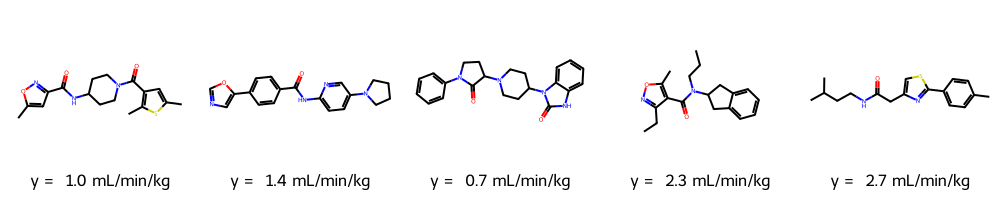

In [2]:
task = "LOG HLM_CLint (mL/min/kg)"

data = ProcessADMEChemData()
chunk = data.adjusted_valid_entries_per_task[task].head(5)
print(chunk.columns)
img = Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in chunk["smiles"]],
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=[f"y =  {y:.1f} mL/min/kg" for y in chunk["y"]],
)
display(img)

The column `fps` represents the numerical counterparts "fingerprints" of the molecular structures originally described by their SMILES. This transformation of SMILES to numerical values is a crucial step in molecular data featurization.

Generating `fps` involves two parameters: length of the feature vectors (`bits`) and degree of detail captured (`radius`). Below we show Pearson's r correlation between predicted and test values. The setting `bits` to `1024` and `radius` to `2` gives a good balance between vector length and the accuracy of predictions.

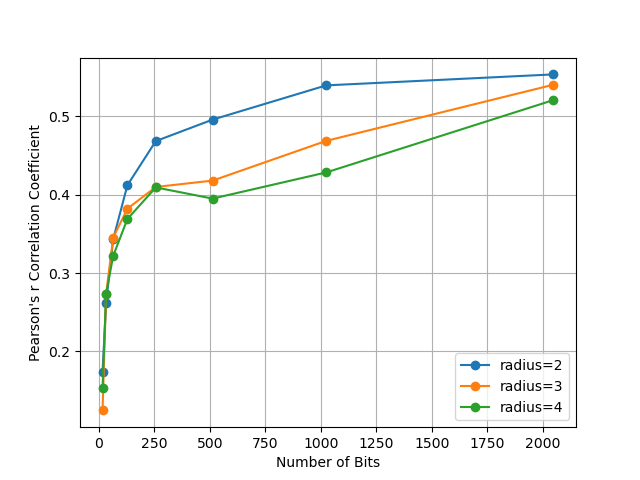

In [3]:
display(Image(filename="performance_bits.png",  width=500, height=300))

To improve the accuracy of the model further, we included several molecular "descriptors", such as the molecular weight or the molecular composition. Note, that only transforming the molecular SMILES into a numerical representation vector is not enough to hide its identity. Such information is sensitive as it would help a competitor to identify the molecules. 

Finally load the complete dataset with train test set splits!

In [4]:
X_train, X_test, y_train, y_test = load_ADME_data(task, bits=1024, radius=2)

Before we fit a model with ZAMA's `FHE` functions, it is essential to conduct hyperparameter optimization with `hyper_opt`. This process uses a parameter grid `param_grid`, and `sklearn` functions. For simplicity `hyper_opt` defines a reasonable choice of default hyperparameters internally. Due to computational costs, we perform the search without FHE and later use the best parameters for the final FHE model. Afterwards, we compare the predictions.

Our model choice is a Linear Support Vector Regression `LinearSVR`, given that our target variable is a continuous value.

`concrete-ml` offers more sophisticated ML models, such as a FHE version of `XGBoostRegressor`. However, we select the linear model for the following reasons:

1. Evaluating linear models in FHE is very fast
2. They are less susceptible to overfitting, making them a more robust choice in scenarios where model generalization is critical.
3. In our case we find that the linear model performs as well as `XGBoostRegressor`

In [5]:
reg_type = "SVR"  # "XGB" or "SVR"

best_params, best_score, best_model = hyper_opt(
    X_train, y_train, param_grid=None, regressor=reg_type, verbose=0
)

with open("best_params_demo.json", "w") as fp:
    json.dump(best_params, fp, default=convert_numpy)


pearsonr_score = evaluate_model(best_model, X_test, y_test)
print("Hyperparameter tuning results: ")
print(best_params)
print(f"Best model Pearson R score: {pearsonr_score:.3f}")

Hyperparameter tuning results: 
{'C': 0.01, 'dual': True, 'epsilon': 0.1, 'loss': 'squared_epsilon_insensitive', 'max_iter': 50000, 'tol': 0.0001}
Best model Pearson R score: 0.634


The model achieves a correlation coefficient of `0.63`. When using the XGBoostRegressor (set `reg_type=XGB`) the improvement in the correlation coefficient `0.649` is marginal. Given this small increase in performance versus slighlty higher computational cost when using FHE, we continue with the linear model.

Let's inspect some predictions with a scatterplot. As you will see the model is not perfect, but a Pearson coefficient of around 0.65 was the best one reported in the literature (see refererence [1]).

Text(0, 0.5, 'PREDICTION')

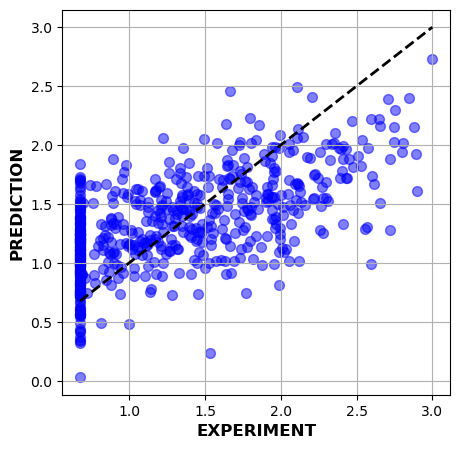

In [6]:
y_pred = best_model.predict(X_test)
x = np.linspace(min(y_test), max(y_test), 100)

plt.figure(figsize=(5, 5))  # Larger figure size
plt.plot(x, x, color="black", ls="--", lw=2)  # Thicker line
plt.scatter(y_test, y_pred, alpha=0.5, s=50, color="blue")  # Bigger, colored markers
plt.grid(True)  # Add grid

# Increase tick size and set labels with bold font
plt.tick_params(axis="both", which="major", labelsize=10)  # Increase tick size
plt.xlabel("EXPERIMENT", fontsize=12, fontweight="bold")  # Bold font for x label
plt.ylabel("PREDICTION", fontsize=12, fontweight="bold")  # Bold font for y label

Finally, we proceed to train and deploy the model in FHE. First, we load the previously determined hyperparameters and train the FHE model using ZAMAs `concrete-ml` library. 

This is as simple as training a model in `sklearn`. The only difference is the need for a quantization parameter. Put simply this is because elementary steps of FHE only perform integer operations. For linear models `best_params["n_bits"] = 12` is a good choice (more about this in ZAMAs documentation).

For linear models such as here, the quantization parameter can be used with quite a large value because they do not require the use of lookup tables compared to XGBoost models.

In [7]:
try:
    with open("best_params_demo.json", "r") as fp:
        best_params = json.load(fp)
        print(best_params)
except:
    print("No hyperparameter file found. Please run the cell above first.")

model_dev_fhe = train_zama(X_train, y_train, best_params, regressor=reg_type)

{'C': 0.01, 'dual': True, 'epsilon': 0.1, 'loss': 'squared_epsilon_insensitive', 'max_iter': 50000, 'tol': 0.0001}
Training Zama model...
compiling model...
done


Now we measure the prediction time for a single test set example in FHE using `LinearSVR`.
You can again go back a couple of cells and train the `XGBoostRegressor` and measure the prediction time for a single example,
you will see that FHE execution is slower.

In [8]:
prediction_time = time_prediction(model_dev_fhe, X_test[0])
print(f"Time to predict one sample: {prediction_time:.2f} seconds")

Time to predict one sample: 0.12 seconds


It only took a fraction of a second (~0.03 s) to predict a single example. 
Try the `XGBoostRegressor` and you will see that it takes much longer (~ 40 s) for a single example using a depth of 6 and 30 estimators.

More extensive shows that prediction time can increase quite substantially with the number of estimators and the depth of the trees. For instance, we tested the prediction time with n_estimators=100 for various max_depth parameters:

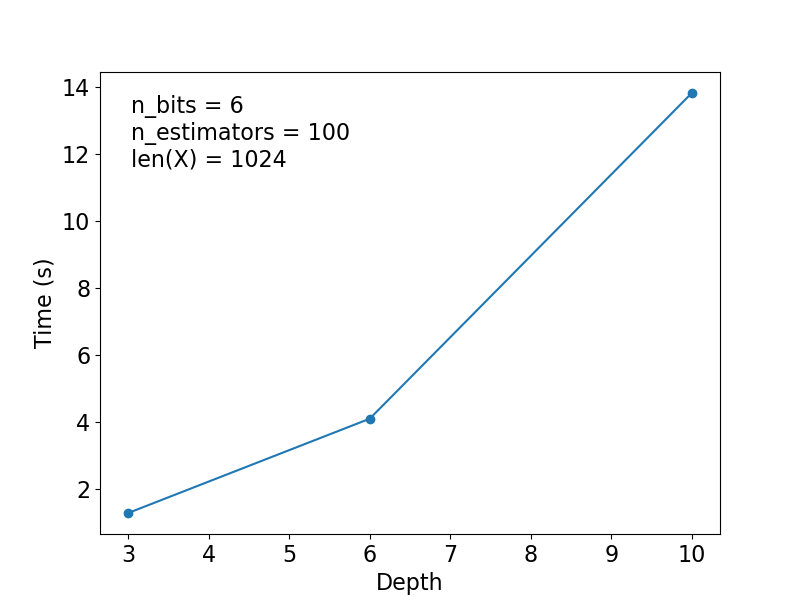

In [9]:
display(Image(filename="FHE_timings.png", width=500, height=300))

These numbers should be taken with a grain of salt as timing depend on the CPU architecture. We find that 100 estimators is too much for this dataset. This highlights that when training `concrete-ml` models is the highest accuracy with the fastest runtime, there is an optimal trade-off to find. 

Next, we set up a virtual network and deploy the model to a subfolder called `deployment`.
This involves:

1) Sending the previously fitted model `model_dev_fhe` from the developer to the server.
2) Send the model specifications to the client.
3) The client sends the evaluation key to the server.
4) The model is evaluated and FHE predictions are compared to the plaintext predictions after decryption with the private client key.

Finally, the model is stored in a subfolder `deployment`. This folder contains all the data needed to deploy the model in an FHE production setting.

In [10]:
network, fhemodel_dev = setup_network(model_dev_fhe)
copied, error_message = copy_directory(network.dev_dir.name, destination="deployment")
if not copied:
    print(f"Error copying directory: {error_message}")

network.dev_send_model_to_server()
network.dev_send_clientspecs_and_modelspecs_to_client()

fhemodel_client, serialized_evaluation_keys = setup_client(
    network, network.client_dir.name
)
print(f"Evaluation keys size: {len(serialized_evaluation_keys) } B")

network.client_send_evaluation_key_to_server(serialized_evaluation_keys)


mae_fhe, pearsonr_score_fhe = compare_predictions(
    network, fhemodel_client, best_model, X_test[-10:]
)

Evaluation keys size: 24 B


KeySetCache: miss, regenerating /tmp/tmpt0gofzbu/15707590456495652960/0_0


sklearn_predictions
[1.93911947 1.23698471 1.49092974 1.67439808 1.03079596 1.84546774
 1.58502499 0.70876342 1.80356574 1.18544338]
fhe_predictions_decrypted:
[1.9299343  1.23228618 1.48588077 1.66157299 1.02531583 1.84574264
 1.57478211 0.70479519 1.78729725 1.18495305]
Pearson's r between sklearn and fhe predictions: 1.00


The correlation between the FHE model and the plaintext model is 1.0 (perfect correlation).
Now that the model is deployed, we can also evaluate it on more molecules using encrypted input.
For instance on vitamin D, ethanol or ibuprofen without revealing the structure of the molecules to the server.

Finally, we can also evaluate the model on molecules that are not in the training set:

In [11]:
VITAMIN = "C=C1CCC(O)CC1=CC=C1CCCC2(C)C1CCC2C(C)C=CC(C)C(C)C"
ETHANOL = "CCO"
IBUPROFEN = "CC(C)Cc1ccc(C(C)C(=O)O)cc1"

pred = predict_ADME(
    network,
    fhemodel_client,
    ETHANOL,
    bits=1024,
    radius=2,
)
print("Prediction: {:.1f} (mL/min/kg)".format(pred[0][0][0]))

Prediction: 0.2 (mL/min/kg)


We have successfully trained an FHE model for predicting molecular properties relevant for drug development. If you want to train and deploy a model on your own dataset, follow the instructions in the README.md file of this repository.